/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/0f72db9c-d635-4415-9781-68937328aed2___NREC_B.Spot 9188.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/1b8d3e98-43d9-441d-93ef-a359e6e9ddc2___NREC_B.Spot 9052.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b6d35d21-4812-4e32-ab9a-b6ddda8cbb79___JR_B.Spot 8972.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/e4e7e5a2-5aa1-4378-833d-9142358c7c9b___JR_B.Spot 9092.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/8b50f2db-cbf2-4758-bea6-a011f0cc1497___JR_B.Spot 3235.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/729b55d7-2a99-4861-910d-3b4e2bbce13a___JR_B.Spot 9036.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG
/kaggle/input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/b143a281-5395-4a2a-830

Let's import the dataset and all the necessary libraries for the model.

In [2]:
# Dataset and Colab Sheet

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import sklearn as sk
import os
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from urllib.request import urlretrieve
%matplotlib inline

Downloading specific folders from the complete dataset.

In [24]:
!cp -r "../input/plant-village/PlantVillage/Potato___Early_blight" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___Late_blight" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Potato___healthy" "/kaggle/working/PlantVillage"

Initialising some parameters for dataset.

In [25]:
#PARAMETERS
FILE_PATH = "PlantVillage"
IMAGE_SIZE = 256 
CHANNELS = 3
EPOCHS = 50
BATCH_SIZE= 32

Loading the dataset.

In [26]:
# oading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
FILE_PATH,
shuffle = True,                                                                                                                                                                           
image_size =(IMAGE_SIZE,IMAGE_SIZE),
batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [27]:
# let's check if correct classes are imported
classes=dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [28]:
len(dataset)

68

In [29]:
dataset.take(1)

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

Let's plot our dataset images with their titles.

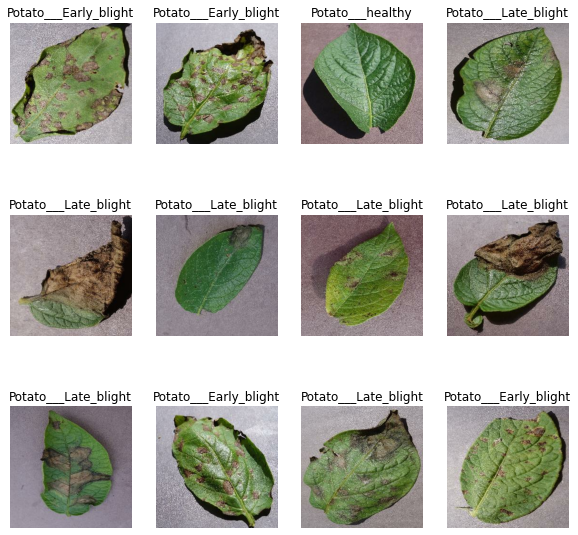

In [30]:
# plot some images from the dataset
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[label_batch[i]])
        plt.axis("off")

### Splitting Database to Train, Test and Validation sets.

In [31]:
def split_data(dataset,train_split, test_split, val_split, shuffle, shuffle_size):
    assert(train_split+test_split+val_split)==1
    ds_size=len(dataset)
    
    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=dataset.take(train_size)
    val_ds=dataset.skip(train_size).take(val_size)
    test_ds=dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [32]:
# def split_data(dataset,train_split, test_split, val_split, shuffle, shuffle_size):   standard function to implement data split
train_df, val_df, test_df=split_data(dataset, 0.8, 0.1, 0.1, True, 1000)

In [33]:
len(train_df)

54

In [34]:
len(test_df)

8

In [35]:
len(val_df)

6

In [36]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Let's create our model

(we will be using TensorFlow for the model creation)

### Creating layers for our Resizing and Regularization

In [37]:
resize_rescale=keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    keras.layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

Let's augment our data to ensure enough training examples of all kinds.

In [38]:
data_augmentation=keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [39]:
train_df=train_df.map(
    lambda x,y:(data_augmentation(x,training=True),y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## MODEL ARCHITECTURE

Let's create our model architecture

In [40]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

Disease_Classifier=tf.keras.models.Sequential([
    resize_rescale,
    keras.layers.Conv2D(32,kernel_size=(3,3), activation='relu',input_shape=input_shape),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64,kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(n_classes, activation='softmax'),
])

In [41]:
Disease_Classifier.build(input_shape=input_shape)

In [42]:
Disease_Classifier.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 30, 30, 64)         

In [43]:
Disease_Classifier.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [44]:
result=Disease_Classifier.fit(train_df,batch_size=BATCH_SIZE,validation_data=val_df,verbose=1,epochs=50)

Epoch 1/50
54/54 [==============================] - 77s 1s/step - loss: 0.9137 - accuracy: 0.4855 - val_loss: 0.8709 - val_accuracy: 0.4375
Epoch 2/50
54/54 [==============================] - 73s 1s/step - loss: 0.7055 - accuracy: 0.6638 - val_loss: 0.5571 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 73s 1s/step - loss: 0.4353 - accuracy: 0.8212 - val_loss: 0.3170 - val_accuracy: 0.8594
Epoch 4/50
54/54 [==============================] - 72s 1s/step - loss: 0.2735 - accuracy: 0.8929 - val_loss: 0.2382 - val_accuracy: 0.9010
Epoch 5/50
54/54 [==============================] - 73s 1s/step - loss: 0.2486 - accuracy: 0.8970 - val_loss: 0.2437 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 72s 1s/step - loss: 0.2120 - accuracy: 0.9225 - val_loss: 0.1689 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 72s 1s/step - loss: 0.1696 - accuracy: 0.9392 - val_loss: 0.1717 - val_accuracy: 0.9219
Epoch 8/50
54/54 [==

In [47]:
scores=Disease_Classifier.evaluate(test_df)

8/8 [==============================] - 2s 296ms/step - loss: 0.0314 - accuracy: 0.9844


In [48]:
scores

[0.03135852515697479, 0.984375]

In [49]:
result

In [50]:
result.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [53]:
result.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
result.history['loss'][:]

[0.9137349724769592,
 0.7055373191833496,
 0.4352949261665344,
 0.2735044062137604,
 0.2485985904932022,
 0.21202395856380463,
 0.1696198582649231,
 0.17196162045001984,
 0.1689678430557251,
 0.15722757577896118,
 0.17621420323848724,
 0.1569417119026184,
 0.13155262172222137,
 0.1362304538488388,
 0.20676739513874054,
 0.14275939762592316,
 0.13393262028694153,
 0.1027694121003151,
 0.09408684819936752,
 0.07147620618343353,
 0.09301599115133286,
 0.0659012496471405,
 0.0549316368997097,
 0.10629545897245407,
 0.07218100130558014,
 0.06523548811674118,
 0.05391739308834076,
 0.057223930954933167,
 0.03749531880021095,
 0.03236592933535576,
 0.026490334421396255,
 0.043455157428979874,
 0.034462109208106995,
 0.03444163501262665,
 0.0252666138112545,
 0.037582676857709885,
 0.053868912160396576,
 0.05396979674696922,
 0.04481879994273186,
 0.06087479367852211,
 0.027679644525051117,
 0.01787477172911167,
 0.02210599184036255,
 0.016892125830054283,
 0.0205223485827446,
 0.0308972932398

In [55]:
accuracy=result.history['accuracy'][:]
val_accuracy=result.history['val_accuracy'][:]
loss=result.history['loss'][:]
val_loss=result.history['val_loss'][:]

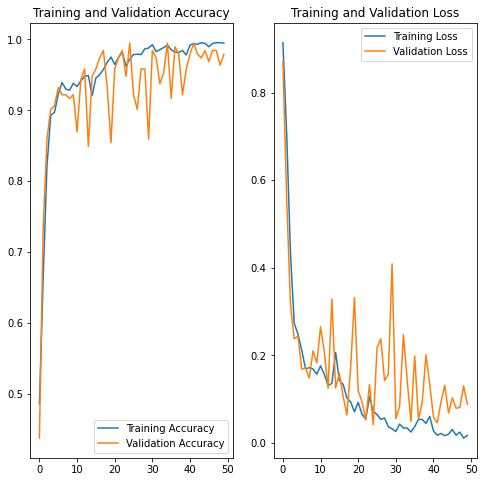

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Running prediction on Test images.

Image to be predicted
First Image
Actual Label :  Potato___Late_blight
Predicted Label :  Potato___Late_blight


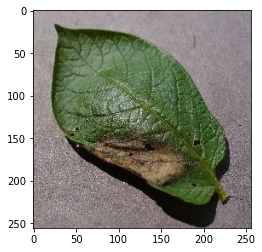

In [61]:
for images_batch, labels_batch in test_df.take(1):
    print('Image to be predicted')
    image=images_batch[0].numpy().astype('uint8')
    label=labels_batch[0].numpy()
    
    p_label=Disease_Classifier.predict(images_batch)
    
    print('First Image')
    plt.imshow(image)
    print('Actual Label : ', classes[label])
    print('Predicted Label : ', classes[np.argmax(p_label[0])])

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

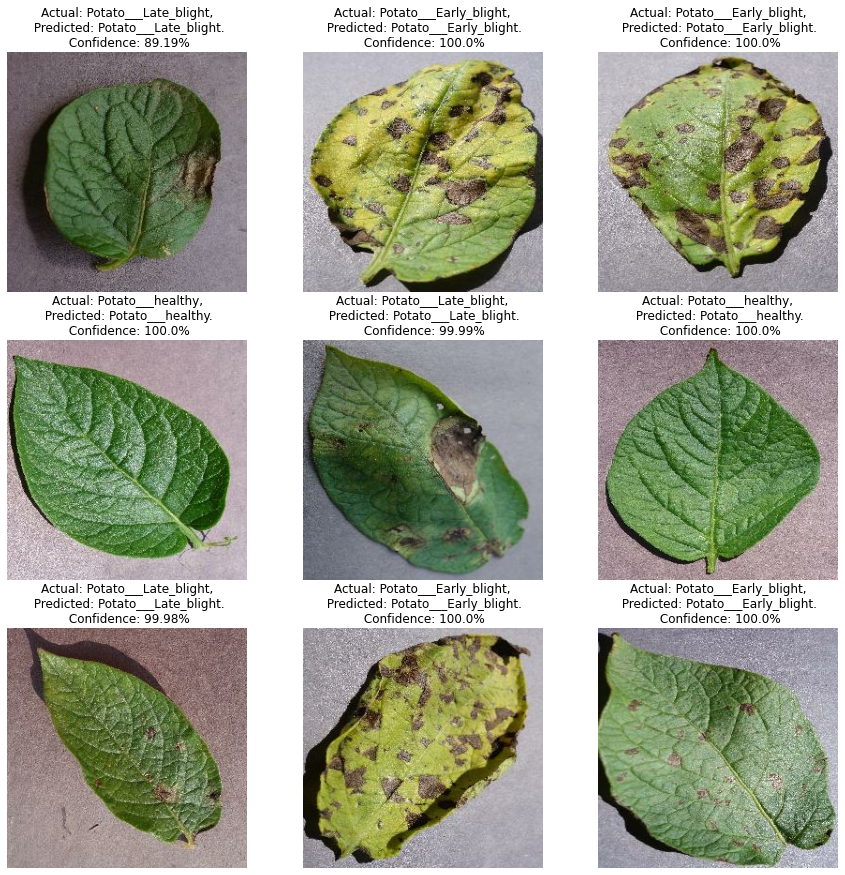

In [70]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(Disease_Classifier, images[i].numpy())
        actual_class = classes[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving our Model

In [72]:
# import pickle

# model_file="Potato_Disease_Classifier.pkl"
# with open(model_file,'wb') as file:
#     pickle.dump(Disease_Classifier, file)

TypeError: can't pickle weakref objects